# **Dependencies**




<h5>
<li>tesseract-ocr package
<li>pytesseract 0.3.8
<li>Open-cv
<li>Pandas
<h5>


---
Using the pytesseract open source library to detect text on image/video.

Open-cv for Image Processing

Pandas for data manipulation










In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 1s (4,248 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import pytesseract


import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:

def process_image(img):
    #Using Open-cv algorithms to denoise the image
    return cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21)


def extract_coords_n_boxes(img, n = -1):
  #Extracting the n-box coords
  processed_img = process_image(img)
  boxes = pytesseract.image_to_boxes(processed_img)
  coords = [cl[2:].split(" ") for cl in boxes.split("0\n")]

  try:
    dig_n = [[int(i) for i in x[:-1]] for x in coords[:n] ]
  except:
    dig_n = [[int(i) for i in x[:-1]] for x in coords[:-1] ]
  
  box_coords = [[(rec[i], img.shape[0] - rec[i+1]) for i in range(0, 3, 2)] for rec in dig_n]
  
  return box_coords

def draw_boxes(img):
  
  boxes = extract_coords_n_boxes(img)
  #drawing the boxes on the image
  for box in boxes:
    cv2.rectangle(img, box[0], box[1], (0, 255 , 0), 1 )
  cv2_imshow(img)


In [ ]:
#trying on a template
img = cv2.imread('1.png')

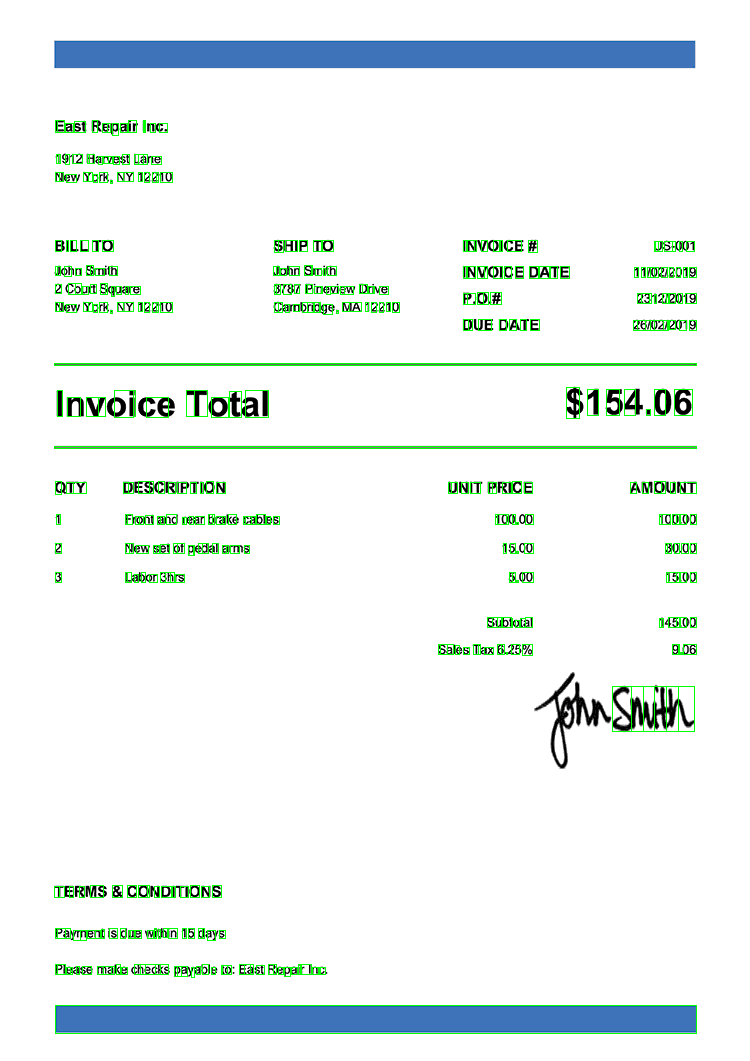

In [ ]:
#drawing each predicted character box on the image
draw_boxes(img)

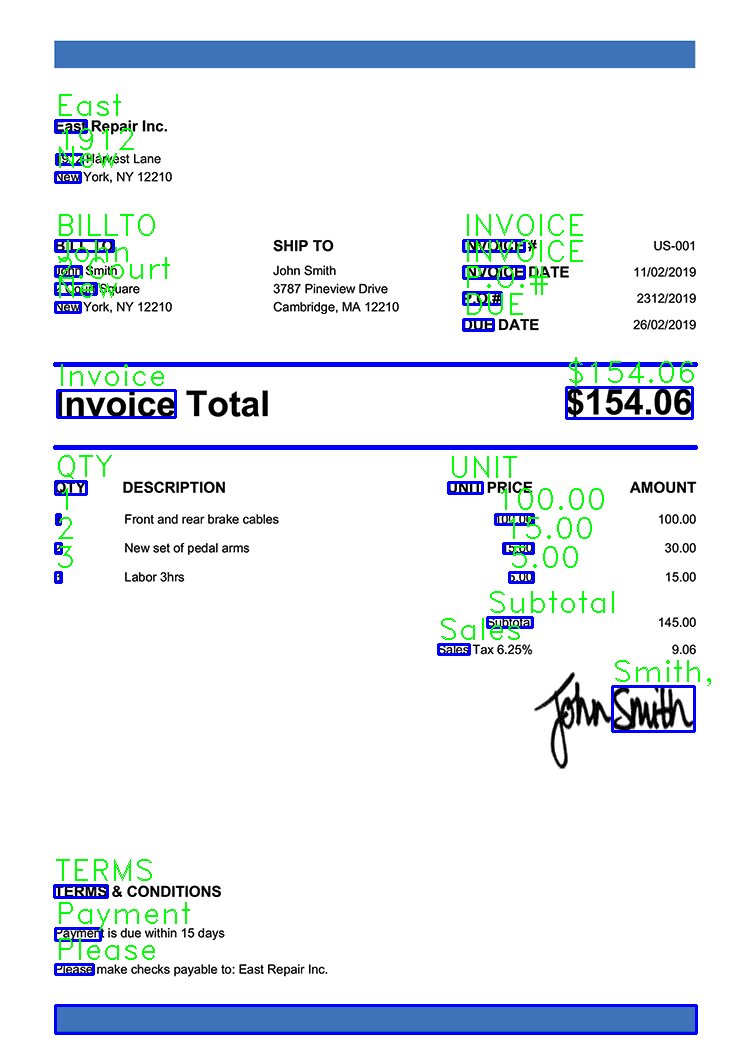

In [ ]:
#Re-calling the initial state of the image before drawing boxes
img = cv2.imread("1.png")
#Using a different method to draw boxes on WORDS and type their meaning on top of them
for i, row in df[df.word_num==1].iterrows():
    xmax = row.left+ row.width # left + width (xmax)
    ymax =row.top + row.height # top + height (ymax)
    cv2.rectangle(
        img, (row.left, row.top), 
        (xmax, ymax), (255, 0, 0), 2
    )
    # write detected text of block
    cv2.putText(img, row[11], (row.left, row.top - 5), cv2.FONT_HERSHEY_DUPLEX, 1, (0, 255, 0), 1)

cv2_imshow(img)

In [ ]:
def invoice_exraction(img_path):
  
  cv2.imread(img_path)
  
  txt = pytesseract.image_to_string('1.png')
  lst = txt.split('\n')
  lst = list(filter(lambda x: True if (x not in ['', ' ']) else False, lst))
  
  report = {}
  report['Invoice Total'] = lst[lst.index("Invoice Total")+1]

  for i, txt in enumerate(lst):
      
      if("INVOICE #" in txt):
        report['id'] = (txt[txt.index('#')+1:]).strip()

      elif("INVOICE DATE" in txt):
        report['Invoice Date'] = (txt[txt.index('TE ')+3:]).strip()
      
      elif ('DUE DATE' in txt):
        report['Due Date'] = (txt[txt.index('TE ')+3:]).strip()
      
      elif ('Subtotal' in txt):
        report['Subtotal'] = txt[txt.index(' ')+1 :]
        price_stack = [[x[:x.index(' ')],x[x.index(' ')+1:]]for x in lst[lst.index('UNIT PRICE AMOUNT'): i]]
        descr_stack = [[x[:x.index(' ')],x[x.index(' ')+1:]]for x in lst[lst.index('QTY DESCRIPTION'): lst.index('TERMS & CONDITIONS')]]
        total_stack = [y + x for x, y in zip(price_stack, descr_stack)]
        report['invoices'] = pd.DataFrame(total_stack[1:], columns = total_stack[0])
      
      elif ('Sales' in txt):
        report['tax'] = txt[txt.index('%')+1:].strip()
        
      return report

{'Due Date': '26/02/2019',
 'Invoice Date': '11/02/2019',
 'Invoice Total': '$154.06',
 'Subtotal': '145,00',
 'id': 'uUs-001',
 'invoices':   QTY                  DESCRIPTION    UNIT PRICE AMOUNT
 0   1  Front and rear brake cables  100.00       100.00
 1   2        New set of pedal arms   15.00        30.00
 2   3                   Labor 3hrs    5.00        15.00,
 'tax': '9.08'}